<a href="https://colab.research.google.com/github/mgjorgje/lasso-calibration/blob/main/ABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We use the libraries numpy and matplotlib for numerical computation and graphical outputs respectively. The library sklearn is exclussively used for the linear lasso model, otherwise we would need to write an optimization algorithm for the lasso. We also import the LassoCV function which will be used
later to check our cross validation error function.

Introduction


The goal of this project is to study the statistical properties of the Akaike information criterium (AIC), Bayesian information criterium (BIC) and Cross validation (CV) for model selection via simulation. We generate Gaussian data $Y=X\beta_*+\epsilon$ where $X$ is an $n$ by $p$ random Gaussian matrix with independent $N(0,1)$ entries, $\beta_*$ is a $p$ dimensional vector (i.e. the true parameter) and $\epsilon$ is $n$ dimensional random vector with $N(0,\sigma I_n)$ distribution, independent from $X$. We are interested in the calibration of the LASSO (Least Absolute Scrhinkage Selection Operator) estimator which is defined by

$\begin{equation*}
\hat{\beta}_{lasso,\lambda}=argmin_{\beta\in\mathbb{R}^p}(||Y-X\beta||^2+\lambda ||\beta||_{1})
\end{equation*}$

The parameter $\lambda$ is known as a regularization parameter and controls the sparsity (i.e. number of nonzero coeficients) of the estimator $\hat{\beta}_{lasso}$. High values of $\lambda$ induce sparsity of the estimator, while low values (close to zero) give results similar to the standard least square estimator. We are concerned with how we should choose the parameter $\lambda$.
The approach will be to employ a model selection criteria such as AIC, BIC, CV, and test their performance over many simulations in various ways. We will study both the low dimensional ($p$ small compared to $n$) and high dimensional regime ($p$ comparable or larger than $n$). We will also study how the noise $\epsilon$ affects the model selection procedure.



In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn 
from sklearn import linear_model
from sklearn.linear_model import LassoCV

We begin by defining some basic functions which will be of use later. In particular the function $pen()$ returns the number of nonzero components of a given vector.

In [21]:
def pen(beta):
  s=0
  for i in range(0,len(beta)):
    if beta[i]!=0:
      s=s+1
  return(s)

def norm(x):
  return(np.dot(x,x))

In [22]:
def lasso_optimizer(LAMBDA):
  if LAMBDA==0:
    lm=linear_model.LinearRegression(fit_intercept=False)
  else:
    lm=linear_model.Lasso(alpha=LAMBDA,fit_intercept=False,max_iter=1000000,tol=0.00001)
  return lm

Now we generate the data.

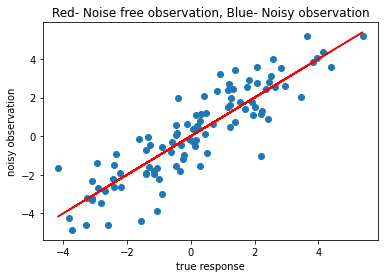

In [23]:
# n = number of samples
n=100
# p = number of features (covariates, explanatory variables)
p=10
#p0 = number of features relevant for the model i.e. Y depends only on these features
p0=5
# sigma = noise of the observation
sigma=1
# beta0 = true parameter

beta0=np.concatenate((np.ones(p0),np.zeros(p-p0)))

# X- data matrix

X=np.random.normal(0,1,size=n*p).reshape(n,p)

# Y- data of noisy observations

Y=np.dot(X,beta0)+np.random.normal(0,sigma,size=n)

plt.title('Red- Noise free observation, Blue- Noisy observation')
plt.scatter(np.dot(X,beta0),Y)
plt.plot(np.dot(X,beta0),np.dot(X,beta0),c='red')
plt.xlabel('true response')
plt.ylabel('noisy observation')

plt.show()

Model selection is performed in the following setting: for a grid of values of $\lambda$, we compute $\hat\beta_{lasso,\lambda}$ using the sklearn library. AIC and BIC are similar for implementation, and are somewhat easier then CV.

Given a finite grid of values $\mathscr{M}$ (which will consist of equally spaced points between two values), the value of $\lambda$ chosen by AIC is 

$\lambda_{AIC}=argmin_{\lambda\in\mathscr{M}} ||Y-X\beta_{lasso,\lambda}||^2+2\sigma^2||\beta_{lasso,\lambda}||_0 $

The value of $\lambda$ chosen by BIC is 

$ \lambda_{BIC}=argmin_{\lambda\in\mathscr{M}} ||Y-X\beta_{lasso,\lambda}||^2+\sigma^2||\beta_{lasso,\lambda}||_0\log(n)$

The following code defines functions that return the best AIC and BIC estimates $\lambda_{AIC}$, $\lambda_{BIC}$, given the data $X$, $Y$, the noise $\sigma$ and the model $\mathscr{M}$ .Note that because the sklearn function linear_model.Lasso() does not converge well for $λ=0$ (in which case we have the usual least square estimator), we fit standard least squares model for $\lambda=0$. In order to simplify the code, we always assume that $\lambda=0$ belongs to our collection of models $\mathscr{M}$.

In [24]:
 def AIC_selector(X,Y,z,sigma):
  aic_0=None
  aerror=None
  forplots=[]

  for i in z:


    if i==z[0]:

      lsm=linear_model.LinearRegression(fit_intercept=False)
      lsm.fit(X,Y)
      beta=lsm.coef_
      aerror=norm(Y-np.dot(X,beta))+2*sigma**2*pen(beta)
      aic_0=0

    else:
      lm=lasso_optimizer(i)
      lm.fit(X,Y)
      beta=lm.coef_


    aic=norm(Y-np.dot(X,beta))+2*sigma**2*pen(beta)
      
    if aic<aerror:
      aerror=aic
      aic_0=i

    forplots.append(aic)
  return(aic_0)

In [25]:
def BIC_selector(X,Y,z,sigma):
  bic_0=None
  berror=None

  for i in z:

    if i==z[0]:
      lsm=linear_model.LinearRegression(fit_intercept=False)
      lsm.fit(X,Y)
      beta=lsm.coef_
      berror=norm(Y-np.dot(X,beta))+np.log(len(Y))*sigma**2*pen(beta)
      bic_0=0

    else:
      lm=lasso_optimizer(i)
      lm.fit(X,Y)
      beta=lm.coef_


    bic=norm(Y-np.dot(X,beta))+np.log(len(Y))*sigma**2*pen(beta)
     
    if bic<berror:
      berror=bic
      bic_0=i
 
  return(bic_0)

In [26]:
z=np.linspace(0,2,300)

lambda_aic=AIC_selector(X,Y,z,1)
lambda_bic=BIC_selector(X,Y,z,1)

lma=lasso_optimizer(lambda_aic)
lma.fit(X,Y)

lmb=lasso_optimizer(lambda_bic)
lmb.fit(X,Y)

print('Lambda_aic = ',lambda_aic,'Beta(lambda_aic) = ', lma.coef_ , 'l_0 norm = ',pen(lma.coef_))
print('Lambda_bic = ',lambda_bic,'Beta(lambda_bic) = ', lmb.coef_, 'l_0 norm = ',pen(lmb.coef_))


Lambda_aic =  0.05351170568561873 Beta(lambda_aic) =  [ 0.80522442  0.83822022  0.93781894  1.2124778   1.07036731 -0.03179771
 -0.          0.         -0.          0.18827936] l_0 norm =  7
Lambda_bic =  0.0802675585284281 Beta(lambda_bic) =  [ 0.76499064  0.8155671   0.90598447  1.16792822  1.033101   -0.
 -0.          0.         -0.          0.15203978] l_0 norm =  6


Let us discuss CV in practice now. CV should, to each $\lambda$ assign an error. CV splits the data into training and testing set, it trains the model on the training set and evaluates its performance on the testing set. This is done for k folds, and the average error is returned. CV will choose $\lambda$ with minimal cross validation error.

$Implementation$

We need to build our own cross validation function. We will use cyclic splitting of the data. In parameter settings, it is advisable to use kfold = number of folds for cross validation such that kfold divides n, otherwise the last few samples will not be used for cross validation. If we set kfold=n, we get the leave one out cross validation, i.e. LOOCV.

In [27]:
# This function takes all the samples with indices outside the range [low,high)
def train_split(X,low,high):
  X_train=X[np.delete(np.arange(len(X)),np.arange(low,high))]
  return(X_train)

# This function takes all the samples with indices in range [low,high)
def test_split(X,low,high):
  X_test=X[np.arange(low,high)]
  return(X_test)

# This is the CV function, LAMBDA stands for the lambda for which we want to
# do the CV procedure, and kfolds stands for the number of folds to be used 

def CV(X,Y,LAMBDA,kfolds):
  lm=lasso_optimizer(LAMBDA)
  i=0
  w=0
  s=int(len(Y)/kfolds)
  while i<len(Y):
    lm.fit(train_split(X,i,i+s),train_split(Y,i,i+s))
    if i+s<len(Y):
      w=w+norm(test_split(Y,i,i+s)-lm.predict(test_split(X,i,i+s)))
    i=i+s
  return(w/kfolds)

Now that we have a cross validation error function, we can select   $\lambda$ 
according to cross validation by testing it on a grid of values like for the AIC and BIC. We also plot the value of the CV criterion as a function of $\lambda$.

In [28]:
# This function returns the cross validation selected value of lambda
# z is the grid on which we choose lambda. 
def CV_selector(X,Y,z):
  cval_0=None
  error=None
  cval=None


  for i in z:
    cval=CV(X,Y,i,10)
  

    if i==z[0]:
      cval_0=i
      error=cval

    if cval<error:

      cval_0=i
      error=cval
  return(cval_0)


In [29]:
z=np.linspace(0,2,50)
our=[]
official=[]

for i in range(0,20):
  X=np.random.normal(0,1,size=n*p).reshape(n,p)
  Y=np.dot(X,beta0)+np.random.normal(0,sigma,size=n)
  our_cv=CV_selector(X,Y,z)
# cv here is the parameter for number of folds
# In python, lambda is called alpha, so alphas=z means we 
# only test along the said grid, instead of the default setting
# of the LassoCV function
  test = LassoCV(cv=10,fit_intercept=False,alphas=z)
# we fit the LassoCV function to our data
  test.fit(X,Y)
# we extract the estimated lambda from LassoCV (direct analogue to cv.glmnet in R)
  cv_official=test.alpha_

  our.append(our_cv)
  official.append(cv_official)

vis=pd.DataFrame(data=[our,official,np.array(our)-np.array(official)],index=['Our cv value','LassoCV cv value','Difference']) 

 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning:

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning:

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning:

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.555559266955356, tolerance: 0.04352780803543566

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning:

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

/

Because the code for cross validation is a bit more sophisticated then simply finding a minimum of a list, it is wise to check if our cross validation function is in fact correct. We do this using the sklearn function LassoCV. It is possible that our cv function and the LassoCV dont match. To see how good our cv function is we do 20 simulations and compare the results. If the results are close, this means our implementation is correct. Note that we have 50 different values for which we test at each iteration. We directly define a function that returns $\lambda_{CV}$ given $X,Y$ and $\mathscr{M}$ 

In [30]:
vis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Our cv value,0.000000,0.040816,0.040816,0.081633,0.000000,0.081633,0.040816,0.0,0.081633,0.040816,0.040816,0.040816,0.040816,0.040816,0.0,0.081633,0.122449,0.040816,0.081633,0.0
LassoCV cv value,0.040816,0.040816,0.040816,0.040816,0.040816,0.081633,0.040816,0.0,0.081633,0.040816,0.040816,0.040816,0.081633,0.040816,0.0,0.081633,0.081633,0.122449,0.081633,0.0
Difference,-0.040816,0.000000,0.000000,0.040816,-0.040816,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.040816,0.000000,0.0,0.000000,0.040816,-0.081633,0.000000,0.0


Keeping in mind that we test 50 values of lambda, we can conclude that our results are pretty close to the LassoCV function, and so our implementation of CV is correct.

The following code defines a function that makes the investigation of the estimators via simulation possible. It takes several parameters, explained in the coments below.

In [31]:
# n = number of samples
# p = number of features
# p0= sparsity level i.e. true features
# sigma = noise of the observation
# M = number of simulations 
# z = grid along which model selection is performed

def Comparator(n,p,p0,sigma,M,z):
  beta0=np.concatenate((np.ones(p0),np.zeros(p-p0)))
  A=[]
  B=[]
  C=[]
  for i in range(0,M):
    X=np.random.normal(0,1,size=n*p).reshape(n,p)
    Y=np.dot(X,beta0)+np.random.normal(0,sigma,size=n)

    alm=lasso_optimizer(AIC_selector(X,Y,z,sigma))
    alm.fit(X,Y)
    A.append(pen(alm.coef_))

    blm=lasso_optimizer(BIC_selector(X,Y,z,sigma))
    blm.fit(X,Y)
    B.append(pen(blm.coef_))

    clm=lasso_optimizer(CV_selector(X,Y,z))
    clm.fit(X,Y)
    C.append(pen(clm.coef_))

  return(A,B,C)

We first investigate the performance of each estimator with fixed noise
$\sigma=1$, sparsity level $p0=5$, and fixed sample size $n=100$. We vary the dimension $p$ starting from 5 in increments of 5 until we reach 200. For each dimension, we run 50 simulations of data $X,Y$, and compute the mean of $\lambda_{AIC}$,$\lambda_{BIC}$ and $\lambda_{CV}$ over those simulations. In the way it is structured, the code easily allows to change the collection of models $\mathscr{M}=z$ and the number of simulations $M$. However, if there is a convergence error message, one needs to increase the number of iterations in lasso_optimizer() defined at the begining of the code. This code runs quite slowly mainly due to the cross validation function being compuatationally demanding.

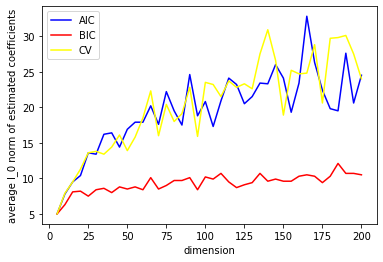

In [32]:
dims=np.arange(1,41)*5
Aerror=[]
Berror=[]
Cerror=[]


for x in dims:
  S=Comparator(100,x,5,1,10,np.linspace(0,2,30))
  Aerror.append(np.mean(S[0]))
  Berror.append(np.mean(S[1]))
  Cerror.append(np.mean(S[2]))

plt.plot(dims,Aerror,label='AIC',c='blue')
plt.plot(dims,Berror,label='BIC',c='red')
plt.plot(dims,Cerror,label='CV',c='yellow')
plt.xlabel('dimension')
plt.ylabel('average l_0 norm of estimated coefficients')
plt.legend()

plt.show()

We plot the results to get an idea how well each estimator performs

Similar computation can be carried out for the influence of noise. Here we fix $n=100$, $p=10$, $p_0=5$, and we wary $\sigma$ from 0 to 9 in increments of 1. The number of simulations $M$ is set to 30. 

In [33]:
noise=np.arange(0,10)

Anoise=[]
Bnoise=[]
Cnoise=[]

for y in noise:
  T=Comparator(100,10,5,y,30,np.linspace(0,2,30))
  Anoise.append(np.mean(T[0]))
  Bnoise.append(np.mean(T[1]))
  Cnoise.append(np.mean(T[2]))

And again we plot the results.

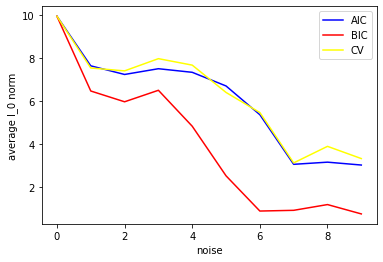

In [34]:
plt.plot(noise,Anoise,color='blue',label='AIC')
plt.plot(noise,Bnoise,color='red',label='BIC')
plt.plot(noise,Cnoise,color='yellow',label='CV')
plt.xlabel('noise')
plt.ylabel('average l_0 norm')
plt.legend()

plt.show()
